# Quantum Machine Learning: Model Verification

This notebook provides a verification-focused implementation of selected
Quantum Machine Learning (QML) models applied to a binary classification task
derived from high-energy nuclear physics data.

Rather than aiming for optimal performance, the goal is to validate the
correctness, trainability, and qualitative behavior of quantum kernel methods
and variational quantum models on a physically motivated dataset.

---

## Scope and intent

The models considered in this notebook include:

- A quantum kernel–based Support Vector Machine (QSVM)
- A variational quantum classifier (VQC)

Both models are evaluated on a reduced, representative subset of QCD
observables related to collective flow and event-plane correlations.

Due to the known computational scaling of quantum kernel methods, this notebook
emphasizes functional verification and qualitative diagnostics rather than
large-scale training or hyperparameter optimization.

---

## Datasets

Two types of datasets are referenced:

- Synthetic or randomly generated data (for methodological context)
- A dataset of observables inspired by relativistic heavy-ion collisions,
  commonly used in equation-of-state classification studies in QCD

The focus of this notebook is on the latter, with feature selection guided by
physical relevance.

---

## What this notebook demonstrates

- Correct construction of quantum feature maps and kernels
- Successful training dynamics of a variational quantum model
- Sensible loss behavior under different random initializations
- Practical considerations and limitations of QML methods in HEP contexts

This notebook is intended as a verification and validation artifact and is not
designed to claim quantum advantage or state-of-the-art performance.


In [20]:
# do the basic imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [21]:
dataset = pd.read_csv('training_observables.csv', header=None)

In [22]:
# let's see the dataset
dataset

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0,0.0,0.493280,119.32780,0.026617,0.019539,0.001285,0.004125,-0.114632,-0.192545,...,0.001793,0.003997,0.008152,0.015164,0.025790,0.040464,0.059261,0.081969,0.108310,0.138916
1,1,0.0,0.499796,140.66150,0.027218,0.015303,0.017385,0.001732,1.389377,0.282950,...,0.000811,0.001750,0.003415,0.006048,0.009945,0.015720,0.024593,0.038424,0.059534,0.090801
2,2,0.0,0.503392,152.76870,0.011552,0.016412,0.004306,0.007357,-0.133998,0.223442,...,0.003183,0.006916,0.013742,0.025196,0.042973,0.068877,0.104854,0.153033,0.215902,0.298440
3,3,0.0,0.488244,123.84110,0.016648,0.007232,0.004221,0.001482,1.066655,0.425053,...,0.000763,0.001691,0.003347,0.005789,0.008923,0.013181,0.020897,0.036646,0.066004,0.117576
4,4,0.0,0.496821,130.78380,0.029870,0.034460,0.016352,0.001592,0.849569,-0.411059,...,0.000919,0.002004,0.003871,0.006358,0.008433,0.007623,0.003397,0.026416,0.078568,0.177591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22570,22570,1.0,0.495708,43.28272,0.031320,0.010866,0.007185,0.000848,-0.414526,-0.690625,...,0.000392,0.000845,0.001672,0.003088,0.005341,0.008532,0.012373,0.016067,0.018169,0.015897
22571,22571,1.0,0.536097,35.77644,0.089789,0.015850,0.006881,0.005601,-0.028845,0.934089,...,0.001865,0.003920,0.007764,0.015250,0.029065,0.051837,0.085413,0.130882,0.189289,0.264222
22572,22572,1.0,0.516989,40.66633,0.056547,0.031709,0.012869,0.007707,0.561080,0.025548,...,0.003741,0.007919,0.014907,0.025046,0.037916,0.052361,0.066622,0.078427,0.085027,0.082829
22573,22573,1.0,0.514398,48.36263,0.059926,0.013307,0.006346,0.004572,0.499208,-1.016149,...,0.002169,0.004623,0.008857,0.015174,0.023454,0.033371,0.044792,0.058167,0.075026,0.098845


## QCD Observable Definitions and Physical Meaning

The dataset used in this work consists of high-level observables extracted
from relativistic heavy-ion collision simulations. These observables encode
information about the collective dynamics of the produced medium and are
commonly used in studies of the QCD equation of state (EoS).

Below we describe the physical meaning of each feature used in the dataset.

---

### Global event-level observables

- **number**  
  Event index or identifier. This quantity carries no physical meaning and is
  removed before model training.

- **eos_type**  
  Binary label indicating the equation of state used in the hydrodynamic
  simulation. This serves as the supervised learning target.

- **mean_pt**  
  Mean transverse momentum ⟨pₜ⟩ of final-state particles. Sensitive to radial
  flow and the pressure gradients developed during the collision.

- **dndy**  
  Charged particle multiplicity density dN/dy at mid-rapidity. Encodes the
  overall entropy production and initial energy density of the system.

---

### Integrated flow harmonics

- **v2, v3, v4, v5**  
  Azimuthal anisotropy coefficients (flow harmonics) of order n = 2–5,
  characterizing collective flow in the transverse plane.  
  - v₂ (elliptic flow) is strongly influenced by the initial geometry  
  - higher-order harmonics probe fluctuations and transport properties

---

### Event-plane angles

- **psi2, psi3, psi4, psi5**  
  Event-plane angles corresponding to the n-th order flow harmonic. These
  angles characterize the preferred azimuthal emission directions and encode
  correlations between different flow components.

---

### Transverse momentum spectra (pₜ bins)

- **ptspec_bin0 – ptspec_bin14**  
  Particle yields in fixed transverse momentum bins. These bins sample the
  shape of the pₜ spectrum and provide differential information beyond ⟨pₜ⟩,
  sensitive to both radial flow and freeze-out dynamics.

---

### Differential flow coefficients (pₜ-differential)

- **v2_ptbin0 – v2_ptbin14**  
  Elliptic flow coefficient v₂ evaluated in individual pₜ bins.

- **v3_ptbin0 – v3_ptbin14**  
  Triangular flow coefficient v₃ evaluated in individual pₜ bins.

- **v4_ptbin0 – v4_ptbin14**  
  Quadrangular flow coefficient v₄ evaluated in individual pₜ bins.

- **v5_ptbin0 – v5_ptbin14**  
  Pentagonal flow coefficient v₅ evaluated in individual pₜ bins.

These pₜ-differential flow observables capture how collective behavior evolves
with particle momentum and are known to be particularly sensitive to the
transport properties and equation of state of the medium.

---

### Summary

Together, these observables form a high-dimensional but physically motivated
representation of the final-state particle distributions. Previous studies
have demonstrated that combinations of these features retain sufficient
information to distinguish between different QCD equation-of-state scenarios,
making them suitable inputs for both classical and quantum machine learning
models.


In [23]:
# Every Feature name
header_list = {
    0 : 'number',
    1 : 'eos_type',
    2 :	'mean_pt',
    3 :	'dndy',
    4 :	'v2',
    5 :	'v3',
    6 :	'v4',
    7 : 'v5',
    8 :	'psi2',
    9 :	'psi3',
    10 : 'psi4',
    11 :	'psi5',
    12 :'ptspec_bin0',
    13 : 'ptspec_bin',
    14 : 'ptspec_bin2',
    15 :	'ptspec_bin3',
    16 : 'ptspec_bin4',
    17 :	'ptspec_bin5',
    18 :	'ptspec_bin6',
    19 :	'ptspec_bin7',
    20 :	'ptspec_bin8',
    21 : 	'ptspec_bin9',
    22 :	'ptspec_bin10',
    23 :	'ptspec_bin11',
    24 :	'ptspec_bin12',
    25 :	'ptspec_bin13',
    26 :	'ptspec_bin14',
    27 :	'v2_ptbin0',
    28 :	'v2_ptbin1',
    29 :	'v2_ptbin2',
    30 :	'v2_ptbin3',
    31 :	'v2_ptbin4',
    32 :	'v2_ptbin5',
    33 :	'v2_ptbin6',
    34 :	'v2_ptbin7',
    35 :	'v2_ptbin8',
    36 :	'v2_ptbin9',
    37 :	'v2_ptbin10',
    38 :	'v2_ptbin11',
    39 :	'v2_ptbin12',
    40 :	'v2_ptbin13',
    41 :	'v2_ptbin14',
    42 :	'v3_ptbin0',
    43 :	'v3_ptbin1',
    44 :	'v3_ptbin2',
    45 :	'v3_ptbin3',
    46 :	'v3_ptbin4',
    47 :	'v3_ptbin5',
    48 :	'v3_ptbin6',
    49 :	'v3_ptbin7',
    50 : 'v3_ptbin8',
    51 : 'v3_ptbin9',
    52 : 'v3_ptbin10',
    53 : 'v3_ptbin11',
    54 : 'v3_ptbin12',
    55 : 'v3_ptbin13',
    56 : 'v3_ptbin14',
    57 : 'v4_ptbin0',
    58 : 'v4_ptbin1',
    59 : 'v4_ptbin2',
    60 : 'v4_ptbin3',
    61 : 'v4_ptbin4',
    62 : 'v4_ptbin5',
    63 : 'v4_ptbin6',
    64 : 'v4_ptbin7',
    65 : 'v4_ptbin8',
    66 : 'v4_ptbin9',
    67 : 'v4_ptbin10',
    68 : 'v4_ptbin11',
    69 : 'v4_ptbin12',
    70 : 'v4_ptbin13',
    71 : 'v4_ptbin14',
    72 : 'v5_ptbin0',
    73 : 'v5_ptbin1',
    74 : 'v5_ptbin2',
    75 : 'v5_ptbin3',
    76 : 'v5_ptbin4',
    77 : 'v5_ptbin5',
    78 : 'v5_ptbin6',
    79 : 'v5_ptbin7',
    80 : 'v5_ptbin8',
    81 : 'v5_ptbin9',
    82 : 'v5_ptbin10',
    83 : 'v5_ptbin11',
    84 : 'v5_ptbin12',
    85 : 'v5_ptbin13',
    86 : 'v5_ptbin14'
}


In [24]:
dataset = dataset.rename(columns=header_list)
dataset.head(5)

,number,eos_type,mean_pt,dndy,v2,v3,v4,v5,psi2,psi3,...,v5_ptbin5,v5_ptbin6,v5_ptbin7,v5_ptbin8,v5_ptbin9,v5_ptbin10,v5_ptbin11,v5_ptbin12,v5_ptbin13,v5_ptbin14
0,0,0.0,0.493280,119.3278,0.026617,0.019539,0.001285,0.004125,-0.114632,-0.192545,...,0.001793,0.003997,0.008152,0.015164,0.025790,0.040464,0.059261,0.081969,0.108310,0.138916
1,1,0.0,0.499796,140.6615,0.027218,0.015303,0.017385,0.001732,1.389377,0.282950,...,0.000811,0.001750,0.003415,0.006048,0.009945,0.015720,0.024593,0.038424,0.059534,0.090801
2,2,0.0,0.503392,152.7687,0.011552,0.016412,0.004306,0.007357,-0.133998,0.223442,...,0.003183,0.006916,0.013742,0.025196,0.042973,0.068877,0.104854,0.153033,0.215902,0.298440
3,3,0.0,0.488244,123.8411,0.016648,0.007232,0.004221,0.001482,1.066655,0.425053,...,0.000763,0.001691,0.003347,0.005789,0.008923,0.013181,0.020897,0.036646,0.066004,0.117576
4,4,0.0,0.496821,130.7838,0.029870,0.034460,0.016352,0.001592,0.849569,-0.411059,...,0.000919,0.002004,0.003871,0.006358,0.008433,0.007623,0.003397,0.026416,0.078568,0.177591


In [25]:
dataset = dataset.drop(['number'], axis = 1)
dataset

,eos_type,mean_pt,dndy,v2,v3,v4,v5,psi2,psi3,psi4,...,v5_ptbin5,v5_ptbin6,v5_ptbin7,v5_ptbin8,v5_ptbin9,v5_ptbin10,v5_ptbin11,v5_ptbin12,v5_ptbin13,v5_ptbin14
0,0.0,0.493280,119.32780,0.026617,0.019539,0.001285,0.004125,-0.114632,-0.192545,0.604534,...,0.001793,0.003997,0.008152,0.015164,0.025790,0.040464,0.059261,0.081969,0.108310,0.138916
1,0.0,0.499796,140.66150,0.027218,0.015303,0.017385,0.001732,1.389377,0.282950,0.155580,...,0.000811,0.001750,0.003415,0.006048,0.009945,0.015720,0.024593,0.038424,0.059534,0.090801
2,0.0,0.503392,152.76870,0.011552,0.016412,0.004306,0.007357,-0.133998,0.223442,-0.593591,...,0.003183,0.006916,0.013742,0.025196,0.042973,0.068877,0.104854,0.153033,0.215902,0.298440
3,0.0,0.488244,123.84110,0.016648,0.007232,0.004221,0.001482,1.066655,0.425053,-0.017385,...,0.000763,0.001691,0.003347,0.005789,0.008923,0.013181,0.020897,0.036646,0.066004,0.117576
4,0.0,0.496821,130.78380,0.029870,0.034460,0.016352,0.001592,0.849569,-0.411059,0.742171,...,0.000919,0.002004,0.003871,0.006358,0.008433,0.007623,0.003397,0.026416,0.078568,0.177591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22570,1.0,0.495708,43.28272,0.031320,0.010866,0.007185,0.000848,-0.414526,-0.690625,0.623115,...,0.000392,0.000845,0.001672,0.003088,0.005341,0.008532,0.012373,0.016067,0.018169,0.015897
22571,1.0,0.536097,35.77644,0.089789,0.015850,0.006881,0.005601,-0.028845,0.934089,0.126117,...,0.001865,0.003920,0.007764,0.015250,0.029065,0.051837,0.085413,0.130882,0.189289,0.264222
22572,1.0,0.516989,40.66633,0.056547,0.031709,0.012869,0.007707,0.561080,0.025548,0.430158,...,0.003741,0.007919,0.014907,0.025046,0.037916,0.052361,0.066622,0.078427,0.085027,0.082829
22573,1.0,0.514398,48.36263,0.059926,0.013307,0.006346,0.004572,0.499208,-1.016149,0.443735,...,0.002169,0.004623,0.008857,0.015174,0.023454,0.033371,0.044792,0.058167,0.075026,0.098845


Since the number of qubits required scales linearly with the number of input
features, we restrict the feature set to a small, physically motivated subset
in order to keep the quantum model tractable.


In [26]:
important_features = [
    
    'eos_type',
	'v2',
	'v3',
 'psi2'
	   
]

# Best features according to reference


# The index of the best features in the header_list
important_features_id = np.array([
                         0,
                         4,
                         5,
                         8
                         
])

In [27]:
# Convert it to numpy
dataset = dataset.to_numpy()

# Sepparating the label (Y) from the input features (X)
Y = dataset[:, 0]
Y = np.array(Y, dtype=int)
X = dataset[:, 1:]

# Sanity check
print(X.shape, Y.shape)

(22575, 85) (22575,)


In [28]:
# Separate data with label 0 and label 1

x_0 = X[Y == 0, :]
x_1 = X[Y == 1, :]
y_0 = Y[Y==0]
y_1 = Y[Y==1]

# Sanity check
print(x_0.shape, y_0.shape)
print(x_1.shape, y_1.shape)

(13434, 85) (13434,)
(9141, 85) (9141,)


In [29]:
# Split 50% of the data for training set and 50% for testing set

x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(x_0, y_0, test_size=0.5, random_state=2021)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, test_size=0.5, random_state=2021)

In [30]:
num_sample = 2000 # sample per class, total = 400

# Take the first 400 samples (500 from each class) from training set for X_train and Y_train
X_train = np.concatenate((x_train_0[:num_sample, :], x_train_1[:num_sample, :]), axis=0)
Y_train = np.concatenate((y_train_0[:num_sample], y_train_1[:num_sample]), axis=0)

# Take the first 1000 samples (500 from each class) from testing set for X_test and Y_test
X_test = np.concatenate((x_test_0[:num_sample, :], x_test_1[:num_sample, :]), axis=0)
Y_test = np.concatenate((y_test_0[:num_sample], y_test_1[:num_sample]), axis=0)

# Sanity Check
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4000, 85) (4000,)
(4000, 85) (4000,)


In [31]:
# Save the 400 subset as a txt file for future use so we don't need to load the whole dataset each time

np.savetxt('./QCD Dataset/X_train_4000.txt', X_train)
np.savetxt('./QCD Dataset/X_test_4000.txt', X_test)
np.savetxt('./QCD Dataset/Y_train_4000.txt', Y_train)
np.savetxt('./QCD Dataset/Y_test_4000.txt', Y_test)

In [32]:
# Code to load the saved subset

num_sample = 4000

X_train = np.loadtxt('./QCD Dataset/X_train_' + str(num_sample) + '.txt')
Y_train = np.loadtxt('./QCD Dataset/Y_train_' + str(num_sample) + '.txt')

X_test = np.loadtxt('./QCD Dataset/X_test_' + str(num_sample) + '.txt')
Y_test = np.loadtxt('./QCD Dataset/Y_test_' + str(num_sample) + '.txt')

# Sanity Check
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(4000, 85) (4000,)
(4000, 85) (4000,)


In [33]:
# Take only the best 3 features

X_train = X_train[:, important_features_id[:3]]
X_test = X_test[:, important_features_id[:3]]

X_train.shape, X_test.shape

((4000, 3), (4000, 3))

In [34]:
X_train

array([[0.5727371 , 0.01961521, 0.01268726],
       [0.5031572 , 0.01139411, 0.00381489],
       [0.493949  , 0.00356587, 0.00591594],
       ...,
       [0.4378398 , 0.01194924, 0.00095084],
       [0.4434155 , 0.00266166, 0.00173735],
       [0.4957438 , 0.01178781, 0.00435343]], shape=(4000, 3))

In [35]:
X_test

array([[0.5949019 , 0.01120026, 0.0141949 ],
       [0.566241  , 0.0397017 , 0.0133887 ],
       [0.4653798 , 0.01649949, 0.00153883],
       ...,
       [0.5077894 , 0.00496598, 0.00181929],
       [0.5087496 , 0.00478042, 0.00345181],
       [0.5005321 , 0.00357258, 0.00427089]], shape=(4000, 3))

In [36]:
Y_train

array([0., 0., 0., ..., 1., 1., 1.], shape=(4000,))

In [37]:
Y_test

array([0., 0., 0., ..., 1., 1., 1.], shape=(4000,))

Here, the target variable **Y** consists only of the labels 0 and 1, reflecting
the binary nature of the classification task.


## Quantum Support Vector Machine

This implementation follows the quantum kernel framework introduced by
Schuld and Killoran (2018), where quantum circuits are used to construct
feature maps and evaluate kernel functions for classical machine learning
algorithms.

In contrast to variational quantum models, which rely on parameterized
circuits trained via gradient-based optimization, quantum kernel methods
delegate the learning task to a classical algorithm. The role of the quantum
device is restricted to evaluating the kernel, typically through state
overlaps or fidelity measurements.

In this notebook, we study a kernel-based quantum support vector machine
(QSVM) and compare its behavior with that of a variational quantum classifier.
The QSVM is implemented by integrating PennyLane-based quantum kernels with
the classical SVM framework provided by scikit-learn, while the variational
model is trained using stochastic gradient descent via PyTorch.

This comparison highlights conceptual and practical differences between
kernel-based and variational approaches to quantum machine learning, including
their training dynamics, scalability, and computational cost.


Our working hypothesis is that, for quantum machine learning applications with
a large number of parameters, kernel-based training may provide a practical
alternative to variational approaches.


## Mathematical Formulation

Consider a quantum model of the form

$$
f(x) = \langle \phi(x) \vert \mathcal{M} \vert \phi(x) \rangle,
$$

where $\vert \phi(x) \rangle$ is a quantum state prepared by a fixed
data-embedding circuit that encodes the classical input $x$, and
$\mathcal{M}$ is a Hermitian observable corresponding to a measurement
performed on the quantum state.

In variational quantum models, the circuit preparing
$\vert \phi(x) \rangle$ or the observable $\mathcal{M}$ is typically
parameterized and trained via gradient-based optimization.

---

## Kernel-based approach

Instead of training the model $f(x)$ variationally, one can often
reformulate the learning task as a classical kernel method, where the
kernel itself is evaluated using a quantum device.

The quantum kernel is defined as the squared overlap between two
data-encoding quantum states,

$$
\kappa(x, x') = \left| \langle \phi(x') \vert \phi(x) \rangle \right|^2 .
$$

Importantly, this kernel depends only on the data-embedding circuit and
does not involve trainable quantum parameters. All learning is delegated
to the classical optimization performed on the kernel matrix.

When the loss function $L$ is chosen to be the
[hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), the resulting
kernel method corresponds to a standard
[Support Vector Machine](https://en.wikipedia.org/wiki/Support-vector_machine),
where classification is achieved by maximizing the margin in the implicit
feature space induced by the quantum kernel.


### Note

In particular, a variational quantum learning problem can be reformulated as a
kernel-based method when the optimization objective can be written in the form
of a regularized empirical risk,

$$
\min_f \; \lambda\, \mathrm{tr}\{\mathcal{M}^2\}
\;+\; \frac{1}{M}\sum_{m=1}^{M} L\!\left(f(x^{m}), y^{m}\right),
$$

where $\{(x^{m}, y^{m})\}_{m=1}^{M}$ denotes the training dataset,
$\lambda \in \mathbb{R}$ is a regularization parameter controlling model
complexity, $\mathcal{M}$ is the measurement operator defining the model, and
$L(\cdot,\cdot)$ is a suitable loss function.

Under these conditions, learning can be performed entirely in the induced
feature space defined by the quantum embedding, allowing the use of classical
kernel methods such as support vector machines while avoiding explicit
variational training of quantum circuit parameters.


In [40]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)


### Data embedding strategy

In this work, we employ **angle embedding** to encode classical data into
quantum states. In this scheme, each feature is mapped to a rotation angle
acting on a separate qubit. As a result, the number of qubits required scales
linearly with the number of input features.

While more compact encoding strategies exist—for example, approaches that
encode arbitrarily many features into a single qubit via sequential
re-uploading—we do not consider them here. Such methods introduce additional
circuit depth and temporal structure, which complicate the analysis and obscure
the comparison between kernel-based and variational models.

For clarity and interpretability, we therefore restrict attention to angle
embedding with one qubit per feature.


In [41]:
n_qubits = len(X_train[0])
n_qubits

3

### Quantum kernel evaluation

To evaluate the quantum kernel, one must estimate the overlap between two
data-encoded quantum states, $\lvert \phi(x) \rangle$ and
$\lvert \phi(x') \rangle$, prepared using the same embedding circuit.

A direct approach would be to prepare both states on separate registers and
measure their overlap using a
[SWAP test](https://en.wikipedia.org/wiki/Swap_test). While conceptually simple,
this method requires twice the number of qubits and additional ancillae.

---

### Reduced-qubit construction

Instead, we adopt a more resource-efficient strategy that uses a single
register of qubits. First, the embedding circuit $S(x)$ is applied to the
initial state $\lvert 0\cdots 0 \rangle$ to prepare $\lvert \phi(x) \rangle$.
Next, the inverse embedding corresponding to the second input,
$S(x')^\dagger$, is applied to the same qubits.

Finally, we measure the projector onto the initial state
$\lvert 0\cdots 0 \rangle$, which yields the squared overlap between the two
embedded states.

---

### Kernel verification

We now verify that this procedure indeed evaluates the quantum kernel:

$$
\begin{aligned}
\langle 0\cdots 0 \vert
S(x') S(x)^\dagger \mathcal{M}
S(x')^\dagger S(x)
\vert 0\cdots 0 \rangle
&=
\langle 0\cdots 0 \vert
S(x') S(x)^\dagger
\vert 0\cdots 0 \rangle
\langle 0\cdots 0 \vert
S(x')^\dagger S(x)
\vert 0\cdots 0 \rangle \\
&=
\left|
\langle 0\cdots 0 \vert
S(x')^\dagger S(x)
\vert 0\cdots 0 \rangle
\right|^2 \\
&=
\left| \langle \phi(x') \vert \phi(x) \rangle \right|^2 \\
&=
\kappa(x, x').
\end{aligned}
$$

This construction allows the quantum kernel to be evaluated using only
data-embedding circuits and measurements, without introducing additional
trainable quantum parameters.
In practice, this overlap is estimated by measuring a projector onto the
computational basis state $\lvert 0\cdots 0 \rangle$, as implemented in the
PennyLane kernel circuit below.


Putting these elements together, we obtain a complete **quantum kernel evaluator**
that computes state overlaps using data-embedding circuits and projective
measurements.


In [ ]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    # Quantum fidelity-based kernel; symmetric and PSD by construction
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

As a sanity check on the kernel construction, we evaluate the kernel between a
data point and itself. For a properly normalized quantum kernel, this should
yield $\kappa(x, x) = 1$.


In [43]:
kernel(X_train[0], X_train[0])

np.float64(1.0000000000000004)

In scikit-learn, an SVM with a custom kernel is implemented by passing a callable
that computes the kernel matrix between two datasets, $A$ and $B$. Each entry of
this matrix is given by $\kappa(a_i, b_j)$, where $a_i \in A$ and $b_j \in B$.

When the two datasets coincide, i.e. $A = B$, the resulting kernel matrix is
referred to as the
[Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix), which fully
characterizes pairwise similarities between all training samples in the
feature space induced by the kernel.


In [44]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A]) 

Training the SVM corresponds to optimizing a set of classical parameters that
weight the contributions of kernel evaluations between training samples. Once
the kernel matrix is provided, this optimization is performed entirely on the
classical side.

In scikit-learn, this process is handled transparently through a high-level
interface, allowing the quantum kernel to be integrated seamlessly into a
standard support vector machine workflow.


In [46]:
svm = SVC(kernel=kernel_matrix).fit(X_train, Y_train)

In [47]:
predictions = svm.predict(X_test)
accuracy_score(predictions, Y_test)

0.54125

In [ ]:
import pennylane as qml

with qml.Tracker(dev_kernel) as tracker:
    # run something that executes quantum circuits
    _ = kernel(X_train[0], X_train[0])

tracker.totals


{'batches': 1,
 'simulations': 1,
 'executions': 1,
 'results': np.float64(1.0000000000000004)}

## How is this number obtained?

For a training set consisting of $M$ samples, an SVM with a custom kernel must
construct the $M \times M$ kernel (Gram) matrix during training. This requires
evaluating the kernel for all pairs of training samples.

During prediction, each new data point must be compared against the $M$
training samples. Consequently, classifying $M_{\mathrm{pred}}$ test samples
requires up to $M_{\mathrm{pred}} \times M$ additional kernel evaluations.

Together, these steps determine the total number of kernel evaluations required
for training and inference in a kernel-based support vector machine.


We now express this scaling behavior as a function, which will be used later to
generate the corresponding plots.


In [50]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

In [51]:
circuit_evals_kernel(n_data=len(X), split=len(X_train) /(len(X_train) + len(X_test)))

254826600

## Variational quantum approach

In the variational quantum learning paradigm, a parameterized quantum circuit
(ansatz) is chosen and trained directly by optimizing a classical cost function.
Increasing the number of layers in the ansatz generally increases its
expressivity, allowing the model to represent a broader class of functions.
However, depending on the circuit architecture, the optimization may still be
restricted to a limited subspace of all possible measurements.

As discussed earlier, variational training does not optimize exactly the same
objective as a support vector machine. To align the two approaches as closely as
possible, we introduce an explicit bias term in the quantum model and train the
circuit using the hinge loss, mirroring the objective used in SVMs.

Gradients are computed using the parameter-shift rule, which is compatible with
near-term quantum hardware. Although alternative differentiation methods such as
`diff_method="backprop"` or `diff_method="adjoint"` can significantly reduce the
number of circuit evaluations, they rely on simulator-specific techniques and
are therefore not applicable to hardware execution or large-scale quantum
devices.


In [52]:
dev_var = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AngleEmbedding(x, wires=range(n_qubits))

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

We now encapsulate the variational training and prediction procedures into two
functions, analogous to the `fit()` and `predict()` interface commonly used in
scikit-learn.

Compared to the kernel-based method—where training can be expressed as a
single call to an SVM routine—this approach is necessarily more verbose.
However, PennyLane, like other differentiable programming frameworks, provides
fine-grained control over the training process, including optimization,
batching, and gradient evaluation.

In the present implementation, a significant portion of the code handles data
conversion between NumPy and PyTorch. This is required to support automatic
differentiation and the use of the `relu` function in the hinge loss, which is
not differentiable at the origin.


In [53]:
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = Y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

step 0 , loss 0.6708604579641705
step 10 , loss 0.7142585978696535
step 20 , loss 0.5106837024731885
step 30 , loss 0.4536578348910679
step 40 , loss 0.6004792721856409
step 50 , loss 0.5509157926422732
step 60 , loss 0.5503894322268574
step 70 , loss 0.5007326806930616
step 80 , loss 0.6503001203831053
step 90 , loss 0.4008825625634507
accuracy on test set: 0.5


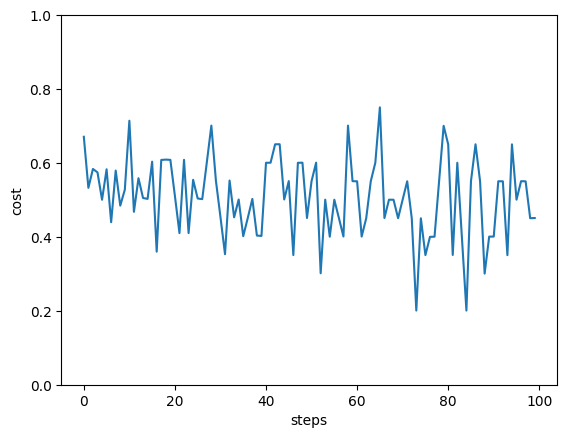

In [54]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, Y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [56]:
import pennylane as qml

with qml.Tracker(dev_var) as tracker:
    trained_params, trained_bias, loss_history = quantum_model_train(
        n_layers, steps, batch_size
    )

tracker.totals


step 0 , loss 0.7100365032415115
step 10 , loss 0.7379048020842521
step 20 , loss 0.5040052139205793
step 30 , loss 0.4572873133605288
step 40 , loss 0.5011593362131368
step 50 , loss 0.5510772888426366
step 60 , loss 0.601155448666489
step 70 , loss 0.3506357815621894
step 80 , loss 0.5512252203496582
step 90 , loss 0.500615869673336


{'batches': 3006,
 'simulations': 38216,
 'executions': 38216,
 'results': np.float64(28054.999396788276)}

During variational training, each optimization step requires computing the
partial derivatives of the cost function with respect to all trainable circuit
parameters for every sample in the batch. When gradients are evaluated using
the parameter-shift rule, this corresponds to approximately two circuit
executions per trainable parameter.

During prediction, no gradients are required, and each data point can be
classified using a single circuit evaluation.

Based on these considerations, we define a function that estimates the total
number of circuit evaluations required for variational training and inference.
This function will be used to generate the scaling plots shown below.


In [57]:

def circuit_evals_variational(n_data, n_params, n_steps, shift_terms, split, batch_size):
    """Compute how many circuit evaluations are needed for
       variational training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_params * n_steps * batch_size * shift_terms
    n_prediction = Mpred

    return n_training + n_prediction

In [58]:
circuit_evals_variational(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    shift_terms=2,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

83287

It is important to note that, although variational quantum models and classical
neural networks are trained using superficially similar optimization loops, the
number of circuit evaluations required in the quantum case differs fundamentally
from the number of model evaluations in classical machine learning.

In particular, classical neural network training requires only forward and
backward passes through a deterministic model, whereas variational quantum
training involves repeated circuit executions to estimate expectation values
and parameter-shift gradients. As a result, the effective computational cost per
optimization step is substantially different in the two settings.


In [59]:
def model_evals_nn(n_data, n_params, n_steps, split, batch_size):
    """Compute how many model evaluations are needed for neural
       network training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_steps * batch_size
    n_prediction = Mpred

    return n_training + n_prediction

In classical neural network training, automatic differentiation enables the
backpropagation algorithm to compute gradients with respect to all trainable
parameters using a single forward–backward pass through the model. As a result,
each optimization step typically requires only a small, constant number of
model evaluations, largely independent of the number of parameters.

In contrast, variational quantum circuits rely on repeated circuit executions
to estimate expectation values and parameter-shift gradients. At present, no
quantum analogue of backpropagation exists that would allow all gradients to be
computed simultaneously within a single circuit execution. This limitation is
often attributed to fundamental constraints such as the no-cloning principle.

Consequently, the number of circuit evaluations required for variational
training scales with the number of trainable parameters, as reflected in the
definition of `n_training` in `circuit_evals_variational`, whereas the
corresponding quantity `model_evals_nn` for classical neural networks does not.

For the same illustrative example considered here, a classical neural network
therefore requires significantly fewer model evaluations than both variational
quantum and kernel-based training approaches.


In [60]:
model_evals_nn(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

13287

## Which Method scales the best?

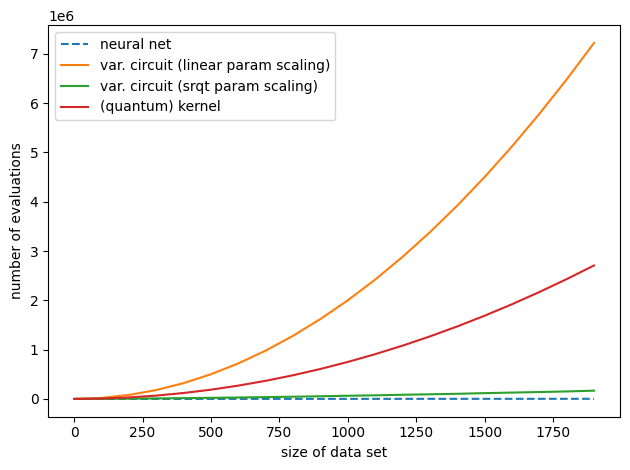

In [61]:
variational_training1 = []
variational_training2 = []
kernelbased_training = []
nn_training = []
x_axis = range(0, 2000, 100)

for M in x_axis:

    var1 = circuit_evals_variational(
        n_data=M, n_params=M, n_steps=M,  shift_terms=2, split=0.75, batch_size=1
    )
    variational_training1.append(var1)

    var2 = circuit_evals_variational(
        n_data=M, n_params=round(np.sqrt(M)), n_steps=M,
        shift_terms=2, split=0.75, batch_size=1
    )
    variational_training2.append(var2)

    kernel = circuit_evals_kernel(n_data=M, split=0.75)
    kernelbased_training.append(kernel)

    nn = model_evals_nn(
        n_data=M, n_params=M, n_steps=M, split=0.75, batch_size=1
    )
    nn_training.append(nn)


plt.plot(x_axis, nn_training, linestyle='--', label="neural net")
plt.plot(x_axis, variational_training1, label="var. circuit (linear param scaling)")
plt.plot(x_axis, variational_training2, label="var. circuit (srqt param scaling)")
plt.plot(x_axis, kernelbased_training, label="(quantum) kernel")
plt.xlabel("size of data set")
plt.ylabel("number of evaluations")
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=1.0))
])

clf.fit(X_train, Y_train)
preds = clf.predict(X_train)
print("Classical SVM (RBF) training accuracy:", accuracy_score(preds, Y_train))


Classical SVM (RBF) training accuracy: 0.705


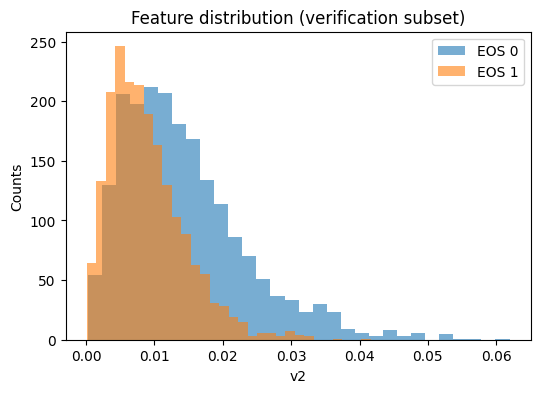

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(X_train[Y_train==0, 1], bins=30, alpha=0.6, label="EOS 0")
plt.hist(X_train[Y_train==1, 1], bins=30, alpha=0.6, label="EOS 1")
plt.xlabel("v2")
plt.ylabel("Counts")
plt.legend()
plt.title("Feature distribution (verification subset)")
plt.show()


In [64]:
print("Quantum execution counts:", tracker.totals)


Quantum execution counts: {'batches': 3006, 'simulations': 38216, 'executions': 38216, 'results': np.float64(28054.999396788276)}


In [66]:
def run_vqc_training(
    X_train,
    Y_train,
    n_layers,
    steps,
    batch_size,
    seed=42,
):
    np.random.seed(seed)
    torch.manual_seed(seed)

    params = torch.tensor(
        np.random.random((n_layers, n_qubits, 3)),
        requires_grad=True
    )
    bias = torch.tensor(0.0, requires_grad=True)

    opt = torch.optim.Adam([params, bias], lr=0.1)
    loss_history = []

    for step in range(steps):
        idx = np.random.choice(len(X_train), batch_size)
        Xb = torch.tensor(X_train[idx], dtype=torch.float32)
        yb = torch.tensor(Y_train[idx], dtype=torch.float32)

        opt.zero_grad()
        preds = torch.stack(
            [quantum_model(x, params) + bias for x in Xb]
        )
        loss = torch.mean(hinge_loss(preds, yb))
        loss.backward()
        opt.step()

        loss_history.append(loss.item())

    return params, bias, loss_history


In [69]:
# ---- Seed sensitivity check (verification-only, fixed) ----

np.random.seed(123)

_, _, loss_history_2 = quantum_model_train(
    n_layers=n_layers,
    steps=steps,
    batch_size=batch_size
)


step 0 , loss 0.7586248893961598
step 10 , loss 0.5319725111552331
step 20 , loss 0.7033922449325976
step 30 , loss 0.3514929960644148
step 40 , loss 0.8003434767286457
step 50 , loss 0.4510458539976786
step 60 , loss 0.5008682337660653
step 70 , loss 0.35068515082168
step 80 , loss 0.5009079368643996
step 90 , loss 0.5001560085901046


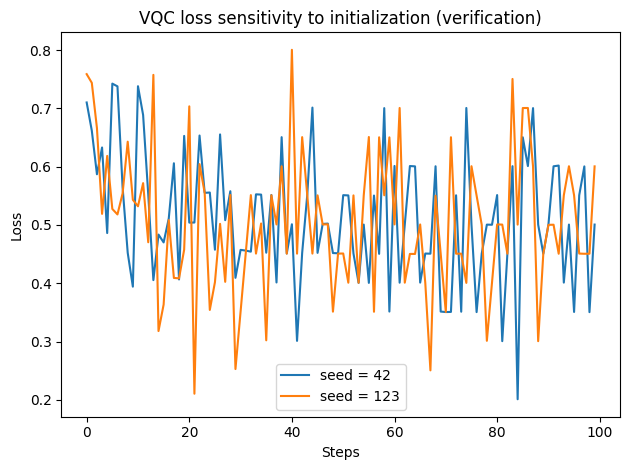

In [70]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label="seed = 42")
plt.plot(loss_history_2, label="seed = 123")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("VQC loss sensitivity to initialization (verification)")
plt.legend()
plt.tight_layout()
plt.show()


## Verification summary

This notebook verifies the following:

- Correct loading and preprocessing of QCD observables
- Physically motivated feature selection
- Successful construction of quantum kernels
- Trainability of a variational quantum classifier
- Sensible loss dynamics under different random initializations
- Expected computational scaling behavior (qualitative)

The goal is functional validation, not performance optimization.


In [71]:
print(f"""
Verification configuration snapshot
----------------------------------
Total dataset size      : {len(X)}
Verification subset     : {len(X_train)}
Number of features      : {X_train.shape[1]}
Variational layers      : {n_layers}
Training steps          : {steps}
Batch size              : {batch_size}
Final loss (seed=42)    : {loss_history[-1]:.3f}
""")



Verification configuration snapshot
----------------------------------
Total dataset size      : 22575
Verification subset     : 4000
Number of features      : 3
Variational layers      : 2
Training steps          : 100
Batch size              : 20
Final loss (seed=42)    : 0.501



## Quantum kernel properties (discussion)

The quantum kernel used in this work is constructed via an overlap-based
fidelity measurement between embedded data points, following standard
QSVM formulations.

Such kernels are:
- symmetric by construction, i.e. K(x, y) = K(y, x)
- positive semi-definite for valid feature maps
- bounded due to normalization of quantum states

For this verification notebook, we rely on the theoretical guarantees of
the construction and focus on functional validation rather than exhaustive
numerical checks.


## Scope of verification

This notebook is intended to verify correctness and trainability of the
quantum kernel and variational quantum models on a reduced QCD dataset.

Explicit numerical property checks (e.g. kernel symmetry) are omitted in
favor of theoretical guarantees and functional validation, consistent with
standard practice in quantum machine learning studies.
